# A General Equilibrium Model

# Setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import time
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from KSModel import KSModelClass

In [2]:
model = KSModelClass('baseline')
print(model)

Modelclass: KSModelClass

Parameters:
 r_ss = nan [float64]
 w_ss = nan [float64]
 kd_ss = nan [float64]
 Y_ss = nan [float64]
 ks_ss = nan [float64]
 C_ss = nan [float64]
 sigma = 1.0 [float64]
 beta = 0.982 [float64]
 Z = 1.0 [float64]
 alpha = 0.11 [float64]
 delta = 0.025 [float64]
 rho = 0.966 [float64]
 sigma_e = 0.5 [float64]
 Ne = 7 [int64]
 a_max = 200.0 [float64]
 Na = 500 [int64]
 tp_T = 500 [int64]
 max_iter_solve = 5000 [int64]
 max_iter_simulate = 5000 [int64]
 solve_tol = 1e-10 [float64]
 simulate_tol = 1e-10 [float64]
 a_grid = array(float64, 1d, C) with shape = (500,)
 e_grid = array(float64, 1d, C) with shape = (7,)
 e_trans = array(float64, 2d, C) with shape = (7, 7)
 e_ergodic = array(float64, 1d, C) with shape = (7,)
 tp_r = array(float64, 1d, C) with shape = (500,)
 tp_w = array(float64, 1d, C) with shape = (500,)
memory, gb: 0.0

Solution:
 a = array(float64, 2d, C) with shape = (7, 500)
 m = array(float64, 2d, C) with shape = (7, 500)
 c = array(float64, 2d, C) 

# Find Steady State

**Step 1:** Find demand and supply of capital for a grid of interest rates.

In [3]:
par = model.par

# a. interest rate trial values
Nr = 100
rvec = np.linspace(0.0,1.0/par.beta-1-0.005,Nr)

# b. allocate
Ks = np.zeros(Nr) 
Kd = np.zeros(Nr)

# c. loop
rmin = 0
rmax = Nr-1
for i_r in range(Nr):
    
    # i. firm side
    k = model.firm_demand(rvec[i_r])
    Kd[i_r] = k*1
    
    # ii. household side
    try:
        
        # solve and simulate
        model.solve_household_ss(r=rvec[i_r])
        model.simulate_household_ss()
        
        # total demand
        Ks[i_r] = np.sum(model.sim.D*model.sol.a)
        
        # bounds on r
        diff = Ks[i_r]-Kd[i_r]
        if diff < 0: rmin = np.fmax(rmin,rvec[i_r])
        if diff > 0: rmax = np.fmin(rmax,rvec[i_r])
            
    except:
        
        Ks[i_r] = np.nan  
        

**Step 2:** Plot supply and demand

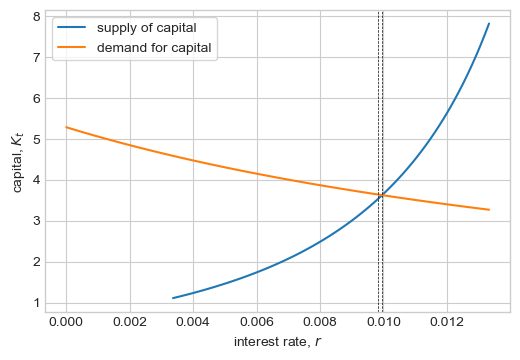

In [4]:
par = model.par

fig = plt.figure(figsize=(6,4),dpi=100)
ax = fig.add_subplot(1,1,1)

ax.plot(rvec,Ks,label='supply of capital')
ax.plot(rvec,Kd,label='demand for capital')

ax.axvline(rmin,lw=0.5,ls='--',color='black')
ax.axvline(rmax,lw=0.5,ls='--',color='black')

ax.legend(frameon=True)
ax.set_xlabel('interest rate, $r$')
ax.set_ylabel('capital, $K_t$');

**Step 3:** Solve root-finding problem

In [5]:
def obj(r,model):

    model.solve_household_ss(r=r)
    model.simulate_household_ss()
    return np.sum(model.sim.D*model.sol.a)-model.firm_demand(r)

sol = optimize.root_scalar(obj,bracket=[rmin,rmax],method='bisect',args=(model,))
assert sol.converged

**Step 4:** Check market clearing conditions.

In [6]:
model.steady_state(sol.root)

household problem solved in 0.1 secs [554 iterations]
household problem simulated in 0.0 secs [708 iterations]

r: 0.0100
w: 1.0255
Y: 1.1522
K/Y: 3.1466

capital market clearing:   0.00000000
goods market clearing:  -0.00000000


# Transition path

**MIT-shock:** Transtion path for exogenous $Z_t$

In [7]:
shock = 1.1
persistence = 0.9

In [8]:
tp_Z = np.ones(par.tp_T)
tp_Z[0] = shock*par.Z
for t in range(1,par.tp_T):
    tp_Z[t] = persistence*tp_Z[t-1] + (1-persistence)*par.Z

**Find transition path with relaxation algorithm:**

In [9]:
# a. allocate
tp_r = model.par.r_ss*np.ones(par.tp_T) # use steady state as initial guess
tp_r_ = np.zeros(par.tp_T)
tp_K = np.zeros(par.tp_T)
tp_w = np.zeros(par.tp_T)

# b. setting
nu = 0.90 # relaxation parameter
max_iter = 5000

# c. iterate
it = 0
while True:
    
    # i. solve and simulate
    model.solve_household_tp(tp_r)
    model.simulate_household_tp()
    
    # ii. implied prices
    for t in range(par.tp_T):
        tp_K[t] = np.sum(model.sim.tp_D[t]*model.sol.tp_a[t])
        tp_w[t] = model.implied_w(tp_r[t])
        tp_r_[t] = model.implied_r(tp_K[t],tp_Z[t])
    
    # iii. difference
    max_abs_diff = np.max(np.abs(tp_r-tp_r_))
    if it%10 == 0: print(f'{it:4d}: {max_abs_diff:.8f}')
    if max_abs_diff < 1e-8: break
    
    # iv. update
    tp_r = nu*tp_r + (1-nu)*tp_r_
    
    # v.  increment
    it += 1
    if it > max_iter: raise Exception('too many iterations')    

   0: 0.00349589
  10: 0.00110222
  20: 0.00035679
  30: 0.00011681
  40: 0.00003851
  50: 0.00001276
  60: 0.00000424
  70: 0.00000142
  80: 0.00000047
  90: 0.00000016
 100: 0.00000005
 110: 0.00000002


**Plot transition-paths:**

Text(0, 0.5, 'wage, $w_t$')

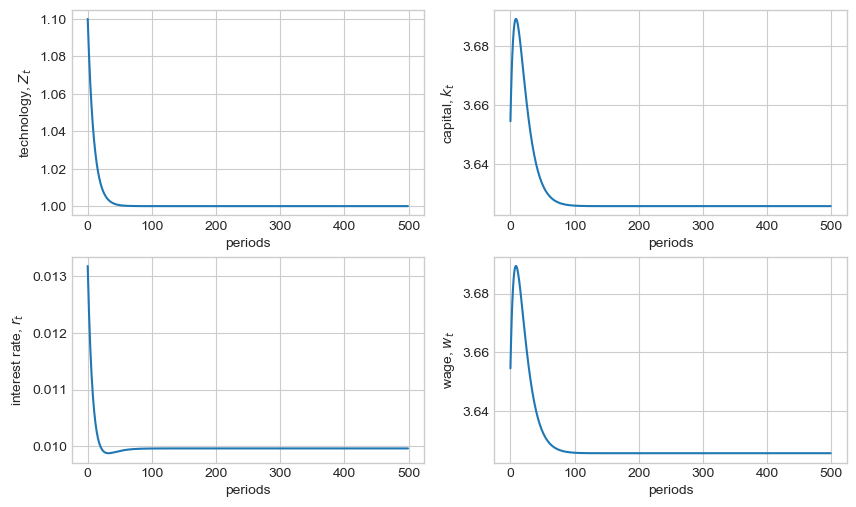

In [10]:
fig = plt.figure(figsize=(10,6),dpi=100)

ax = fig.add_subplot(2,2,1)
ax.plot(np.arange(par.tp_T),tp_Z)
ax.set_xlabel('periods')
ax.set_ylabel('technology, $Z_t$');

ax = fig.add_subplot(2,2,2)
ax.plot(np.arange(par.tp_T),tp_K)
ax.set_xlabel('periods')
ax.set_ylabel('capital, $k_t$');

ax = fig.add_subplot(2,2,3)
ax.plot(np.arange(par.tp_T),tp_r)
ax.set_xlabel('periods')
ax.set_ylabel('interest rate, $r_t$');

ax = fig.add_subplot(2,2,4)
ax.plot(np.arange(par.tp_T),tp_K)
ax.set_xlabel('periods')
ax.set_ylabel('wage, $w_t$')